In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import pandas as pd
import numpy as np
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
train_transform = transforms.Compose([#Compose multi transform functions
              transforms.RandomCrop(size = (32, 32), padding = 4)  ,#Random copping
              transforms.RandomHorizontalFlip(),#Random horizontal flip
              transforms.ToTensor(),
              transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],std=[0.2471, 0.2435, 0.2616])                         
])

test_transform = transforms.Compose([
              transforms.ToTensor(),
              transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],std=[0.2471, 0.2435, 0.2616])
])

In [ ]:
train_data = datasets.CIFAR10(root='data', train=True, transform=train_transform, download=True)
test_data = datasets.CIFAR10(root='data', train=False, transform=test_transform)

Files already downloaded and verified


In [ ]:
valid_transform = test_transform
valid_data = test_data

In [ ]:
train_data

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: data
    Split: Train
    StandardTransform
Transform: Compose(
               RandomCrop(size=(32, 32), padding=4)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2471, 0.2435, 0.2616])
           )

In [ ]:
test_data

Dataset CIFAR10
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2471, 0.2435, 0.2616])
           )

In [ ]:
batch_size = 128
train_loader = DataLoader(dataset=train_data, batch_size=128, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=128, shuffle=False)
valid_loader = test_loader

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


label: [    3     5     9     4     9     8     5     5     3     2     9     2
     1     5     9     0     7     5     1     6     0     2     2     7
     5     3     5     9     2     3     4     9     7     9     3     3
     6     1     0     7     9     5     5     5     7     3     2     8
     0     4     9     4     0     1     8     4     3     6     2     0
     2     6     8     8     4     3     2     9     4     2     7     5
     6     2     3     8     4     4     7     5     9     7     6     6
     3     9     0     9     4     7     9     1     8     2     1     7
     6     1     5     4     5     2     4     1     4     0     3     5
     5     2     3     8     9     8     3     1     7     9     6     8
     3     6     3     1     1     5     8     9]
class: cat dog truck deer truck ship dog dog cat bird truck bird car dog truck plane horse dog car frog plane bird bird horse dog cat dog truck bird cat deer truck horse truck cat cat frog car plane horse truck do

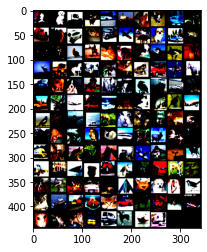

In [ ]:
class_names = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
np.set_printoptions(formatter=dict(int=lambda x: f'{x:5}'))#to widen the printed array
#Grab the first batch of 10 images
for images, label in train_loader:
  break

#print the labels
print('label:', label.numpy())
print('class:', *np.array([class_names[i] for i in label]))

#print the images
im = make_grid(images, nrow = 10)#the default nrow is 8
plt.figure(figsize=(10,4))
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)))

### Define Residual Block

In [ ]:
import time
from torch import nn, optim
class Residual(nn.Module):
  def __init__(self, in_channels, out_channels, use_1x1conv=False, stride=1):
    super(Residual, self).__init__()
    self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=(3,3), padding=1, stride=stride)
    self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=(3,3), padding=1, stride=1)
    #second conv layer has s=1 but first can be 2 sometimes
    if use_1x1conv:
      self.conv3 = nn.Conv2d(in_channels, out_channels, kernel_size=(1,1), stride=stride)
    else:
      self.conv3 = None
    
    self.bn1 = nn.BatchNorm2d(out_channels)
    self.bn2 = nn.BatchNorm2d(out_channels)

  def forward(self, X):
    Y = F.relu(self.bn1(self.conv1(X)))
    Y = self.bn2(self.conv2(Y))
    if self.conv3:
        X = self.conv3(X)
    return F.relu(Y + X)


In [ ]:
#case 1
blk = Residual(3, 3)
X = torch.rand((4, 3, 6, 6))
blk(X).shape

torch.Size([4, 3, 6, 6])

In [ ]:
#case 2
blk = Residual(3, 6, use_1x1conv=True, stride=2)
X = torch.rand((4, 3, 6, 6))
blk(X).shape

torch.Size([4, 6, 3, 3])

### Define the Model

In [ ]:
#in resnet 4 residual block makes of 1 block, so resnet_18 = 4x4 + starting 7x7 conv + 1 FC 
#so resnet23= 4x5 + 7x7 conv + 2FC
def resnet_block(in_channels, out_channels, num_residuals, first_block=False):
  if first_block:
    assert in_channels == out_channels # same channels for in and out
  blk = []
  for i in range(num_residuals):
    if i==0 and not first_block:
      blk.append(Residual(in_channels, out_channels, use_1x1conv=True, stride=2))
    else:
      blk.append(Residual(out_channels, out_channels))
  
  return nn.Sequential(*blk)


In [ ]:
class Resnet23(torch.nn.Module):
  def __init__(self, num_classes):
    super(Resnet23, self).__init__()
    self.block1 = nn.Sequential(
      nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1, stride=1),
      nn.BatchNorm2d(64),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=3, stride=2, padding=1    
    ))
    self.block2 = nn.Sequential(
        resnet_block(64, 64, 2, first_block=True))
    self.block3 = nn.Sequential(
        resnet_block(64, 128, 2)
    )
    self.block4 = nn.Sequential(
        resnet_block(128, 256, 2)
    )
    self.block5 = nn.Sequential(
        resnet_block(256, 512, 4)
    )
    self.avgpool = nn.AdaptiveAvgPool2d(output_size=(1, 1))
    self.fc1 = nn.Linear(512, 1024)
    self.fc2 = nn.Linear(1024, 10)

  def forward(self,X):
    logits = self.block1(X)
    logits = self.block2(logits)
    logits = self.block3(logits)
    logits = self.block4(logits)
    logits = self.block5(logits)
    logits = self.avgpool(logits)
    logits = logits.reshape(X.shape[0], -1)
    logits = self.fc1(logits)
    logits = self.fc2(logits)
    probas = F.softmax(logits,dim = 1)
    return logits, probas

In [ ]:
X = torch.rand((2, 3, 32, 32)).to(device)
model = Resnet23(10).to(device)
print(model)
y = model(X)
print(y)

Resnet23(
  (block1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (block2): Sequential(
    (0): Sequential(
      (0): Residual(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): Residual(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running

In [ ]:
learning_rate = 0.01

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, nesterov=True)
# optimizer = optim.Adam(model.parameters(), lr=1e-3)
# optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=40, gamma=0.1, verbose = True)
def compute_accuracy_and_loss(model, data_loader, device):
    correct_pred, num_examples = 0, 0
    cross_entropy = 0.
    for i, (features, targets) in enumerate(data_loader):
            
        features = features.to(device)
        targets = targets.to(device)

        logits, probas = model(features)
        cross_entropy += F.cross_entropy(logits, targets).item()
        _, predicted_labels = torch.max(probas, 1)
        num_examples += targets.size(0)
        correct_pred += (predicted_labels == targets).sum()
    return correct_pred.float()/num_examples * 100, cross_entropy/num_examples
    

import time
start_time = time.time()

epochs = 120
train_losses = []
val_losses = []
train_accs = []
val_accs = []


for i in range(epochs):
    model.train()
    
    # Run the training batches
    for batch_idx, (X_train, y_train) in enumerate(train_loader):#50000/64 = 782 batches

        X_train, y_train = X_train.to(device), y_train.to(device)
        # Apply the model
        logits, probas = model(X_train)
        loss = F.cross_entropy(logits, y_train)
        
        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if not batch_idx % 300:
            print (f'Epoch: {i+1:03d}/{epochs:03d} | '
                   f'Batch {batch_idx:03d}/{len(train_loader):03d} |' 
                   f' Cost: {loss:.4f}')
        
    scheduler.step()
    model.eval()
    # Run the testing batches
    with torch.no_grad():
        train_acc, train_loss = compute_accuracy_and_loss(model, train_loader, device=device)
        valid_acc, valid_loss = compute_accuracy_and_loss(model, valid_loader, device=device)
        train_accs.append(train_acc)
        val_accs.append(valid_acc)
        train_losses.append(train_loss)
        val_losses.append(valid_loss)
        print(f'Epoch: {i+1:03d}/{epochs:03d} Train Acc.: {train_acc:.2f}%'
              f' | Validation Acc.: {valid_acc:.2f}%')
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed         

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch: 001/120 | Batch 000/391 | Cost: 2.3941
Epoch: 001/120 | Batch 300/391 | Cost: 1.1620
Adjusting learning rate of group 0 to 1.0000e-02.
Epoch: 001/120 Train Acc.: 53.17% | Validation Acc.: 54.99%
Epoch: 002/120 | Batch 000/391 | Cost: 1.3474
Epoch: 002/120 | Batch 300/391 | Cost: 0.7503
Adjusting learning rate of group 0 to 1.0000e-02.
Epoch: 002/120 Train Acc.: 70.86% | Validation Acc.: 70.89%
Epoch: 003/120 | Batch 000/391 | Cost: 1.0588
Epoch: 003/120 | Batch 300/391 | Cost: 0.6238
Adjusting learning rate of group 0 to 1.0000e-02.
Epoch: 003/120 Train Acc.: 71.93% | Validation Acc.: 72.81%
Epoch: 004/120 | Batch 000/391 | Cost: 0.7688
Epoch: 004/120 | Batch 300/391 | Cost: 0.4989
Adjusting learning rate of group 0 to 1.0000e-02.
Epoch: 004/120 Train Acc.: 78.53% | Validation Acc.: 77.82%
Epoch: 005/120 | Batch 000/391 | Cost: 0.5104
Epoch: 005/120 | Batch 300/391 | Cost: 0.5735
Adjusting learning rate of group 0 to 1.0000e-02.


In [ ]:
model.eval()
with torch.set_grad_enabled(False): # save memory during inference
    test_acc, test_loss = compute_accuracy_and_loss(model, test_loader, device)
    print(f'Test accuracy: {test_acc:.2f}%')

Test accuracy: 90.96%


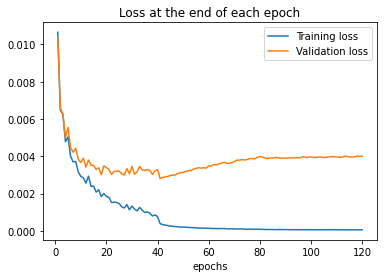

In [ ]:
plt.plot(range(1, epochs+1), train_losses, label='Training loss')
plt.plot(range(1, epochs+1), val_losses, label='Validation loss')
plt.title('Loss at the end of each epoch')
plt.xlabel('epochs')
plt.legend();

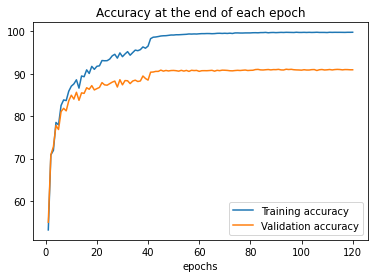

In [ ]:
plt.plot(range(1, epochs+1), train_accs, label='Training accuracy')
plt.plot(range(1, epochs+1), val_accs, label='Validation accuracy')
plt.title('Accuracy at the end of each epoch')
plt.xlabel('epochs')
plt.legend()